# CAPSTONE PROJECT - RESTUARANTS IN MALTA

## Introduction: Business Problem

Hi There!

In this project we will try to find the ideal location for opening a new restuarant abroad. The target audience of this report will be potential stakeholders who are interested in opening a restuarant in Malta. Our goal would be to pick a location which maximises the rating and/or number of likes our restuarant will likely receive.

There are loads of factors to take into account when picking the right location. This report will look into whether the population density, proximity to nearby historic sites have any relationship on the performance of the restuarants.

We will use our data analytics skills to obtain a shortlist of possible areas that are worth considering by the stakeholders.

Populating the interactive namespace from numpy and matplotlib


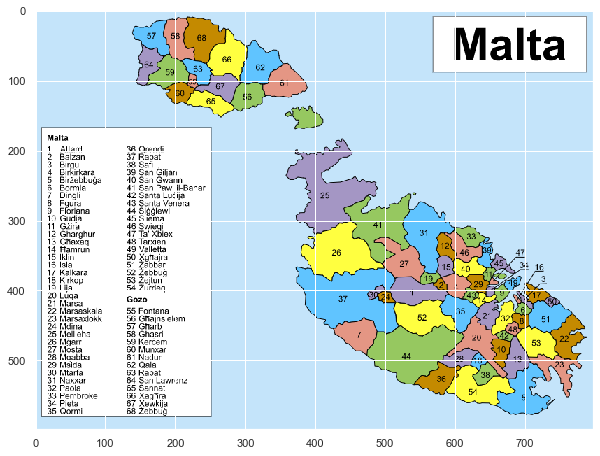

In [83]:
%pylab inline
import matplotlib.pyplot as plt;import matplotlib.image as mpimg
plt.figure(figsize=(10,10));img = mpimg.imread('Malta_Councils.png');imgplot = plt.imshow(img);plt.show()

### Percentage of Foreigners to total population of each locality (2017)

Populating the interactive namespace from numpy and matplotlib


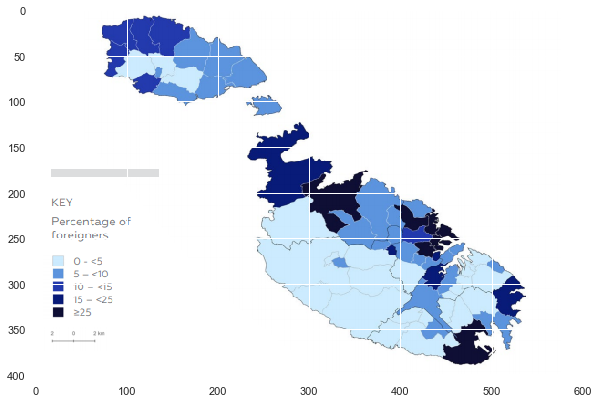

In [79]:
%pylab inline
import matplotlib.pyplot as plt;import matplotlib.image as mpimg
plt.figure(figsize=(10,10));img = mpimg.imread('Malta_Councils_Pop_Density.png');imgplot = plt.imshow(img);plt.show()

## Data Section

Based on our business problem, we will need to observe the following variables:
- Distance of restuarants to nearby historic sites
- Estimated Population Density in the vicinity of the restuarants
- Ratings of each restuarant
- Likes of each restuarant


In order to obtain the longitude/latitude of restuarants and historic sites in Malta, we have extracted the data from the **Foursquare API**.
Longitude/Latitude of Malta Councils and their associated Population Density have been extracted from Wikipedia.

## Initial Data Preparation

#### Imports of required packages

In [306]:
from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim 
import requests
import branca.colormap as bcm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import csv
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
import random # library for random number generation

!pip install seaborn
import seaborn as sns; sns.set()

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

In [5]:
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20201218'
LIMIT = 500
radius = 10000

### Extract Venues 
Given the Foursquares API only extracts a maximum of 100 records each time it is called, we can create a 10x10 grid around the island of Malta and run the API for each coordinate and deduplicate the list of venues received.

In [7]:
a = np.linspace(35.79,36.00,num = 10) #35.79 - 36.09 for including GOZO
b = np.linspace(14.17,14.57,num = 10)
venues = pd.DataFrame([])

for i in a:
    for j in b:
        neighborhood_latitude = i
        neighborhood_longitude = j
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            neighborhood_latitude, 
            neighborhood_longitude, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        results = results['response']['groups'][0]['items']
        results = json_normalize(results)
        venues = venues.append(results)

In [9]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues =venues.loc[:, filtered_columns]
# filter the category for each row
venues['venue.categories'] = venues.apply(get_category_type, axis=1)
# clean columns
venues.columns = [col.split(".")[-1] for col in venues.columns]

#### 5958 total venues has been deduplicated to 527 unique venues:

In [8]:
venues.shape
#venues.head()

(5958, 22)

In [64]:
nearby_venues = venues.drop_duplicates()
nearby_venues.shape

(527, 5)

### Extract Longitude,Latitude and Population Density of Malta Councils

In [23]:
Malta_Councils = pd.read_excel('Malta Councils.xlsx')
Malta_Councils.head()

,Name,Island,Area,Population,Population Density,Latitude,Longitude
0,Attard,Malta,6.6,11377,1723.787879,35.892778,14.438333
1,Balzan,Malta,0.6,4689,7815.000000,35.898056,14.453333
2,Birgu,Malta,0.5,2489,4978.000000,35.888056,14.522500
3,Birkirkara,Malta,2.7,24356,9020.740741,35.896667,14.462500
4,Birzebbuga,Malta,9.2,12915,1403.804348,35.825556,14.528056


### Subset the Data

Subset the data to venues to "Historic Sites" and also those that appear to fall into a "food category", such as Restuarants, Cafés, Bars, Diners, Pizza places, Coffee places.

In [221]:
categories_counts = nearby_venues[['categories','name']].groupby('categories').count().reset_index().sort_values('name', ascending=False)
categories_counts.columns = ['categories','count']
categories_counts = categories_counts[categories_counts['count'] > 5]

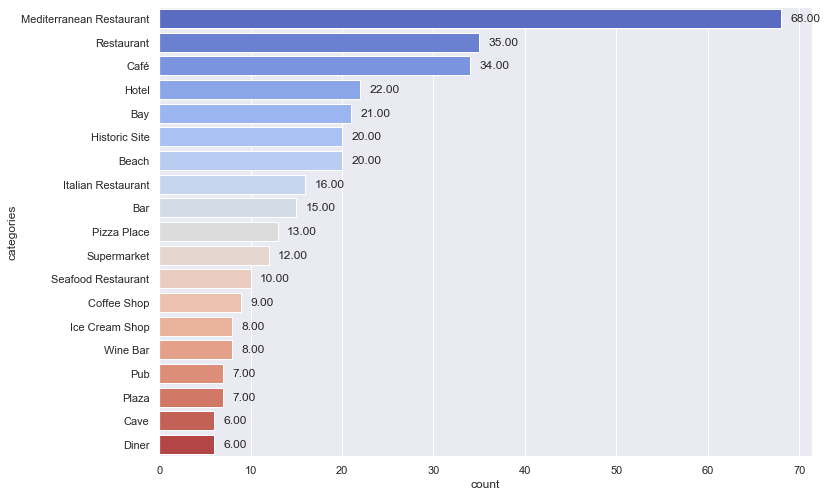

In [222]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g =sns.barplot(x="count",y="categories", data=categories_counts,palette="coolwarm")
for p in g.patches:
    width = p.get_width()    # get bar length
    g.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

In [237]:
contain_values = nearby_venues[nearby_venues['categories'].str.contains('Restaurant|Café|Bar|Diner|Pizza|coffee|Historic Site')]
contain_values['Label'] = np.where(contain_values['categories'].str.contains('Historic Site'), 1, 2)
contain_values = contain_values.reset_index(drop = True) 
contain_values.shape

C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(263, 6)

### Extract ratings and likes for each venue. 
These will be used as our dependent variables in the analysis.

In [246]:
def get_likes(Venue_ID):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                Venue_ID,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION)
    likes = requests.get(url).json()    
    try:
        obj = likes['response']['likes']['count']
    except KeyError:
        obj = 'no likes'
    return obj    

In [247]:
def get_rating(Venue_ID):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                Venue_ID,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION)
    ratings_number = requests.get(url).json()
    try:
        obj = ratings_number['response']['venue']['rating']
    except KeyError:
        obj = 'no rating' 
    return obj    

In [252]:
#contain_values['likes'] = contain_values.apply(lambda x: get_likes(x['id']), axis=1)
contain_values['rating'] = contain_values.apply(lambda x: get_rating(x['id']), axis=1)

In [359]:
#backed_up = contain_values
backed_up.head()
#contain_values[['rating','name']].groupby('rating').count()
#contain_values[['likes','name']].groupby('likes').count()

,id,name,categories,lat,lng,Label,rating
0,4f3cf1e7e4b02d5ef815d185,The Cliffs,Mediterranean Restaurant,35.853782,14.379652,2,6.6
1,4d207fab756e8cfac6d36c54,Bobbyland Bar & Restaurant,Mediterranean Restaurant,35.858796,14.372551,2,6.4
2,52ff4d4d498e3e88d44c3eaf,Diar il-Bniet,Mediterranean Restaurant,35.862120,14.384453,2,8.5
3,4b6d45f2f964a520b06e2ce3,Ħaġar Qim Temples,Historic Site,35.827639,14.442086,1,8.3
4,4dd91ef852b1a5c644753665,Mnajdra Temples,Historic Site,35.826643,14.436346,1,7.8


## Data Analysis

In [259]:
venues_map = folium.Map(location=[contain_values.lat.mean(),contain_values.lng.mean()]) # generate map
venues_map

colors_array = cm.brg(np.linspace(0, 1, 3))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the restaurants as blue circle markers
for lat,lng,label in zip(contain_values.lat, contain_values.lng, contain_values.Label):
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        fill = True,
        label = label,
        color=rainbow[label-1],
        fill_color=rainbow[label-1],
        fill_opacity=1
    ).add_to(venues_map)
    
lat_interval = 5
lon_interval = 6

for lat in np.linspace(35.7, 36.1, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(venues_map)

for lon in np.linspace(14.1, 14.6, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(venues_map)
    
    
# display map
venues_map

In [18]:
import math
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

### Formula I have chosen to measure the how close historic sites are to restuarants:

### Historic Proximity: $\frac{n^{2}}{|\sum \limits _{i = 1} ^{n} |x - h_i|}$

where n is the number of sites within a given radius, x is the restuarant and h is the historic site

In [19]:
def hist_proximity(lat1,long1,radius):
    historics = pd.DataFrame()
    for name, a, b in contain_values[['name','lat','lng']][contain_values['Label'] == 1].itertuples(index=False):
            lat2 = a
            long2 = b
            df = pd.DataFrame([name,distance((lat1, long1),(lat2, long2))]).transpose()
            historics = historics.append(df)
    historics = historics.rename(index=str, columns={0:'name', 1:'distance'})
    historics = historics[historics['distance'] <= radius]
    if len(historics) != 0:
        return(1/((historics['distance'].mean())/len(historics)))
    else: 
        return(100)

In [260]:
Restuarants = contain_values[contain_values['Label'] == 2]
Historic_Sites = contain_values[contain_values['Label'] == 1]

In [261]:
Restuarants['Historic_Proximity'] = Restuarants.apply(lambda x: hist_proximity(x['lat'], x['lng'],10), axis=1)

C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [262]:
venues_map = folium.Map(location=[Malta_Councils.Latitude.mean(),Malta_Councils.Longitude.mean()]) # generate map
venues_map

# add the Italian restaurants as blue circle markers
for lat, lng in zip(Malta_Councils.Latitude, Malta_Councils.Longitude):
    folium.CircleMarker(
        [lat,lng],
        radius=10,
        fill = True,
        label = label,
        color='black',
        fill_color='blue',
        fill_opacity=1
    ).add_to(venues_map)  
    
# display map
venues_map

In [263]:
def Get_Council(lat1,long1):
    historics = pd.DataFrame()
    for name, a, b in Malta_Councils[['Name','Latitude','Longitude']].itertuples(index=False):
            lat2 = a
            long2 = b
            df = pd.DataFrame([name,distance((lat1, long1),(lat2, long2))]).transpose()
            historics = historics.append(df)
    historics = historics.rename(index=str, columns={0:'name', 1:'distance'})
    return(historics[historics.distance == historics.distance.min()]['name'])

In [264]:
def Get_Pop_Density(lat1,long1):
    historics = pd.DataFrame()
    for name, a, b in Malta_Councils[['Population Density','Latitude','Longitude']].itertuples(index=False):
            lat2 = a
            long2 = b
            df = pd.DataFrame([name,distance((lat1, long1),(lat2, long2))]).transpose()
            historics = historics.append(df)
    historics = historics.rename(index=str, columns={0:'Population Density', 1:'distance'})
    return(historics[historics.distance == historics.distance.min()]['Population Density']) 

In [265]:
def Get_PD_Bucket(PD):
    if 0 < PD <= 1000:
        return(1)
    if 1000 < PD <= 5000:
        return(2)
    if 5000 < PD <= 10000:
        return(3)
    if 10000 < PD:
        return(4)

In [266]:
Restuarants['Council'] = Restuarants.apply(lambda x: Get_Council(x['lat'], x['lng']), axis=1)
Restuarants['Population_Density'] = Restuarants.apply(lambda x: Get_Pop_Density(x['lat'], x['lng']), axis=1)
Restuarants['Population_Density_Bucket'] = Restuarants.apply(lambda x: Get_PD_Bucket(x['Population_Density']), axis=1)

C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [267]:
Restuarants.head(10)

,id,name,categories,lat,lng,Label,rating,Historic_Proximity,Council,Population_Density,Population_Density_Bucket
0,4f3cf1e7e4b02d5ef815d185,The Cliffs,Mediterranean Restaurant,35.853782,14.379652,2,6.6,0.971451,Dingli,651.052632,1
1,4d207fab756e8cfac6d36c54,Bobbyland Bar & Restaurant,Mediterranean Restaurant,35.858796,14.372551,2,6.4,0.966896,Dingli,651.052632,1
2,52ff4d4d498e3e88d44c3eaf,Diar il-Bniet,Mediterranean Restaurant,35.862120,14.384453,2,8.5,1.064673,Dingli,651.052632,1
5,4f93ebe4e4b03cc49d3b7963,Hagar Qim Restaurant,Diner,35.826932,14.443263,2,5.5,1.426688,Qrendi,571.428571,1
6,502d2f7be4b0eed9c27ec2c1,Talbot & Bons,Wine Bar,35.851223,14.494721,2,7.9,2.262681,Gudja,1384.347826,2
7,5974c26cf96b2c032000cdd8,Districtfive,Modern European Restaurant,35.825526,14.530570,2,7.9,1.590556,Birzebbuga,1403.804348,2
8,4bca13c70687ef3b7135dbcc,Ferretti Restaurant,Restaurant,35.832365,14.533964,2,7.7,1.710038,Birzebbuga,1403.804348,2
9,524d4859498ea4a1ee258b1e,Zen Sushi to go,Sushi Restaurant,35.850970,14.494697,2,7.4,2.257499,Gudja,1384.347826,2
10,558eafec498e241c914fe3e7,Vecchia Napoli,Italian Restaurant,35.851031,14.494636,2,7.2,2.258572,Gudja,1384.347826,2
11,4e3991d8e4cd799aaef2817a,Al Fresco,Restaurant,35.832379,14.530586,2,7.3,1.736452,Birzebbuga,1403.804348,2


In [76]:
Restuarants['Population_Density_Bucket'].value_counts()

1    105
2     86
3     44
4      8
Name: Population_Density_Bucket, dtype: int64

### Regression: Understand relationship between Historic Sites and Population Density

In [358]:
venues_map = folium.Map(location=[Restuarants.lat.mean(),Restuarants.lng.mean()]) # generate map
venues_map

colors_array = cm.coolwarm(np.linspace(0, 1, 4))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the Italian restaurants as blue circle markers
for lat, lng,Population_Density_Bucket in zip(Restuarants.lat, Restuarants.lng, Restuarants.Population_Density_Bucket):
    folium.CircleMarker(
        [lat,lng],
        radius=7,
        fill = True,
        label = Population_Density_Bucket,
        color=rainbow[Population_Density_Bucket-1],
        fill_color=rainbow[Population_Density_Bucket-1],
        fill_opacity=1
    ).add_to(venues_map)  
    
colormap_dept = bcm.StepColormap(
    colors=rainbow,
    vmin=0,
    vmax=20000,
    index=[0,1000,5000,10000,20000])
colormap_dept.add_to(venues_map)   
    
for lat, lng in zip(Historic_Sites.lat, Historic_Sites.lng):
    folium.CircleMarker(
        [lat,lng],
        radius=7,
        fill = True,
        color="black",
        fill_color="black",
        fill_opacity=1
    ).add_to(venues_map)    
# display map
venues_map

In [39]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

C:\Users\Knowhow\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


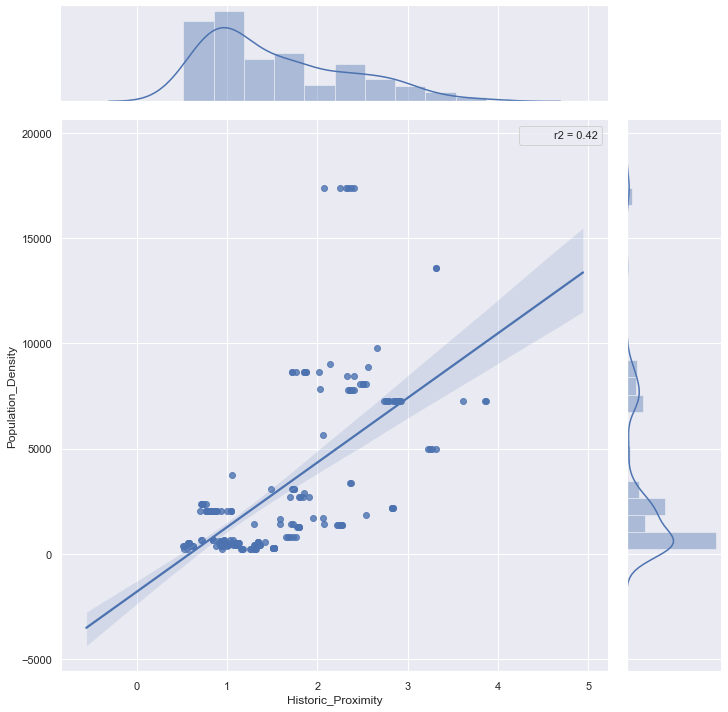

In [40]:
#sns.regplot(x="Historic_Proximity", y="Population_Density", data=Restuarants)
sns.jointplot(x="Historic_Proximity", y="Population_Density", data=Restuarants, kind="reg",stat_func=r2,height=10)

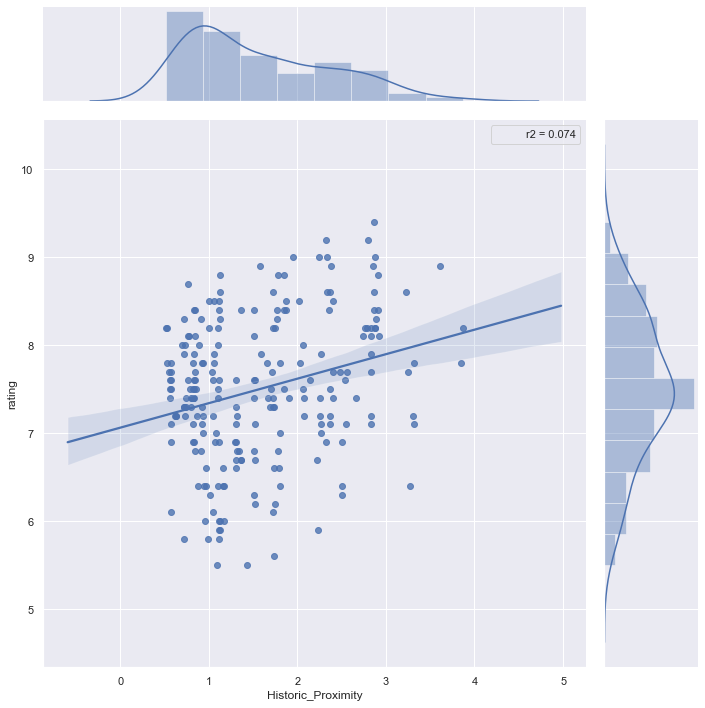

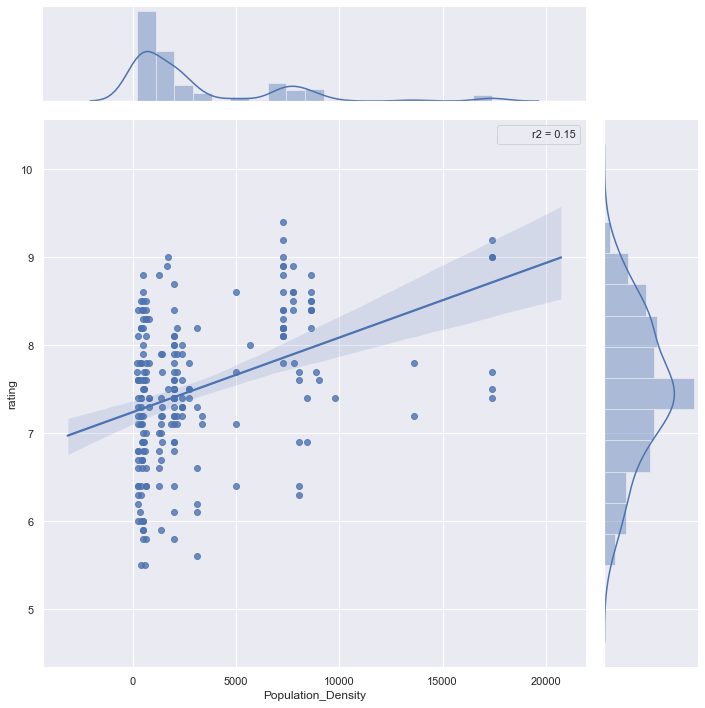

In [362]:
#fig, ax =plt.subplots(1,2)
sns.jointplot(x="Historic_Proximity", y="rating", data=Restuarants[Restuarants['rating'] != 'no rating'], kind="reg",stat_func=r2,height=10)
sns.jointplot(x="Population_Density", y="rating", data=Restuarants[Restuarants['rating'] != 'no rating'], kind="reg",stat_func=r2,height=10)

### KMeans Clustering: Apply "elbow curve" to determine K value to be used in KMeans Algorithm

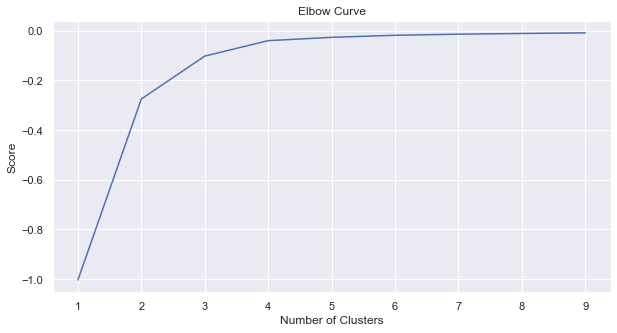

In [35]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = Restuarants[['lat']]
X_axis = Restuarants[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.figure(figsize=(10,5))
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [77]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(Restuarants[['lat','lng']]) # Compute k-means clustering.
Restuarants['cluster_label'] = kmeans.fit_predict(Restuarants[['lat','lng']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(Restuarants[['lat','lng']]) # Labels of each point

C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [216]:
venues_map = folium.Map(location=[Restuarants.lat.mean(),Restuarants.lng.mean()]) # generate map
venues_map

kclusters = 3
colors_array = cm.brg(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the Italian restaurants as blue circle markers
for lat, lng,label in zip(Restuarants.lat, Restuarants.lng, Restuarants.cluster_label):
    folium.CircleMarker(
        [lat,lng],
        radius=4,
        fill = True,
        label = label,
        color=rainbow[label-1],#"black",
        fill_color=rainbow[label-1],
        fill_opacity=0.7
    ).add_to(venues_map)  
    
for lat, lng in zip(Historic_Sites.lat, Historic_Sites.lng):
    folium.CircleMarker(
        [lat,lng],
        radius=4,
        fill = True,
        color="black",
        fill_color="black",
        fill_opacity=1
    ).add_to(venues_map)      
    
# display map
venues_map

## Create Model

In [280]:
Restuarants_Ratings = Restuarants[Restuarants['rating'] != 'no rating']

In [282]:
Restuarants_Ratings.head()

,id,name,categories,lat,lng,Label,rating,Historic_Proximity,Council,Population_Density,Population_Density_Bucket
0,4f3cf1e7e4b02d5ef815d185,The Cliffs,Mediterranean Restaurant,35.853782,14.379652,2,6.6,0.971451,Dingli,651.052632,1
1,4d207fab756e8cfac6d36c54,Bobbyland Bar & Restaurant,Mediterranean Restaurant,35.858796,14.372551,2,6.4,0.966896,Dingli,651.052632,1
2,52ff4d4d498e3e88d44c3eaf,Diar il-Bniet,Mediterranean Restaurant,35.862120,14.384453,2,8.5,1.064673,Dingli,651.052632,1
5,4f93ebe4e4b03cc49d3b7963,Hagar Qim Restaurant,Diner,35.826932,14.443263,2,5.5,1.426688,Qrendi,571.428571,1
6,502d2f7be4b0eed9c27ec2c1,Talbot & Bons,Wine Bar,35.851223,14.494721,2,7.9,2.262681,Gudja,1384.347826,2


In [283]:
#Restuarants_Ratings[['rating']].head()
Restuarants_Ratings[['Historic_Proximity','Population_Density']].head()

,Historic_Proximity,Population_Density
0,0.971451,651.052632
1,0.966896,651.052632
2,1.064673,651.052632
5,1.426688,571.428571
6,2.262681,1384.347826


In [291]:
model = LinearRegression()

In [292]:
model.fit(Restuarants_Ratings[['Historic_Proximity','Population_Density']], Restuarants_Ratings[['rating']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [364]:
model.score(Restuarants_Ratings[['Historic_Proximity','Population_Density']], Restuarants_Ratings[['rating']])

0.15378140097793935

## Optimisation: Test on random Coordinates

In [45]:
import geopandas as gpd
import descartes

In [58]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fp = "malta-latest-free.shp"
map_df = gpd.read_file(fp)
#map_df.plot()
#map_df.to_excel('Coordinates.xlsx', index = False)

In [59]:
coords = pd.read_excel('Coordinates_Long_Lat.xlsx')

In [296]:
coords_sample = coords.sample(n = 10000)

In [367]:
coords_sample['Historic_Proximity'] = coords_sample.apply(lambda x: hist_proximity(x['Latitude'], x['Longitude'],10), axis=1)
coords_sample['Population_Density'] = coords_sample.apply(lambda x: Get_Pop_Density(x['Latitude'], x['Longitude']), axis=1)
coords_sample['Population_Density_Bucket'] = coords_sample.apply(lambda x: Get_PD_Bucket(x['Population_Density']), axis=1)
coords_sample['Council'] = coords_sample.apply(lambda x: Get_Council(x['Latitude'], x['Longitude']), axis=1)
coords_sample.head()

,Coordinates,Longitude,Latitude,Historic_Proximity,Population_Density,Population_Density_Bucket,Predicted_Rating,Council
116401,14.5564213 35.8344881,14.556421,35.834488,1.397486,778.723404,1,7.310366,Marsaxlokk
1459,14.2175994 36.0269611,14.217599,36.026961,0.565296,519.285714,1,7.261438,Munxar
78418,14.4891163 35.8985532,14.489116,35.898553,2.435649,8066.470588,3,7.929409,Msida
93958,14.5092343 35.9002855,14.509234,35.900286,2.789331,7283.750000,3,7.878652,Valletta
19434,14.3661654 35.9662903,14.366165,35.966290,1.072066,503.938053,1,7.277344,Mellieha


In [368]:
coords_sample['Predicted_Rating'] = model.predict(coords_sample[['Historic_Proximity','Population_Density']])

In [348]:
#coords_sample['Predicted_Rating'].min()
coords_sample['Predicted_Rating'].max()
#coords_sample['Predicted_Rating'].mean()

8.689528914921834

Text(0, 0.5, 'Frequency')

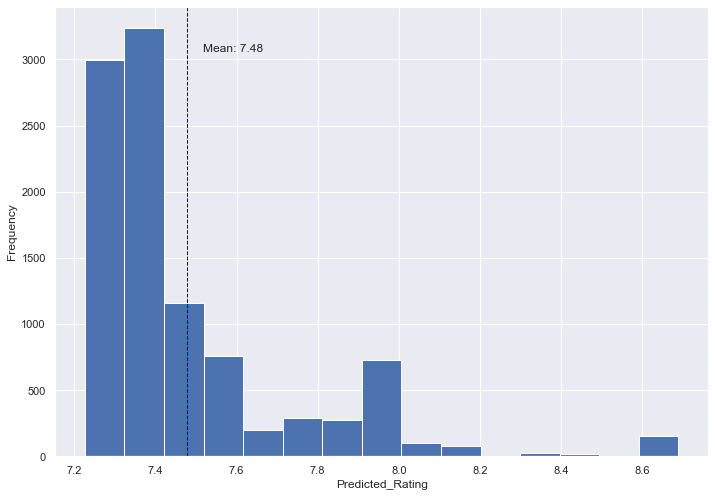

In [369]:
hist(coords_sample['Predicted_Rating'], bins=15)
plt.axvline(coords_sample['Predicted_Rating'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(coords_sample['Predicted_Rating'].mean()*1.005, max_ylim*0.9, 'Mean: {:.2f}'.format(coords_sample['Predicted_Rating'].mean()))
plt.xlabel("Predicted_Rating")
plt.ylabel("Frequency")

In [370]:
coords_sample_plot = coords_sample[coords_sample['Predicted_Rating'] > 7.6]
coords_sample_plot.shape

(1857, 8)

In [371]:
def Get_PR_Bucket(PD):
    if 7.6 < PD <= 7.8:
        return(1)
    if 7.8 < PD <= 8:
        return(2)
    if 8 < PD <= 8.2:
        return(3)
    if 8.2 < PD <= 8.4:
        return(4)
    if 8.4 < PD <= 8.6:
        return(5)
    if 8.6 < PD:     
        return(6)        

In [372]:
coords_sample_plot['Predicted_Rating_Bucket'] = coords_sample_plot.apply(lambda x: Get_PR_Bucket(x['Predicted_Rating']), axis=1)

C:\Users\Knowhow\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [373]:
coords_sample_plot['Predicted_Rating_Bucket'].value_counts()

2    981
1    482
3    197
6    150
4     31
5     16
Name: Predicted_Rating_Bucket, dtype: int64

In [374]:
venues_map = folium.Map(location=[coords_sample_plot.Latitude.mean(),coords_sample_plot.Longitude.mean()]) # generate map
venues_map

colors_array = cm.gist_heat(np.linspace(0, 1, 7))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the Italian restaurants as blue circle markers
for lat, lng,Predicted_Rating_Bucket in zip(coords_sample_plot.Latitude, coords_sample_plot.Longitude, coords_sample_plot.Predicted_Rating_Bucket):
    folium.CircleMarker(
        [lat,lng],
        radius=3,
        fill = True,
        label = Predicted_Rating_Bucket,
        color=rainbow[Predicted_Rating_Bucket-1],
        fill_color=rainbow[Predicted_Rating_Bucket-1],
        fill_opacity=1
    ).add_to(venues_map)  
    
colormap_dept = bcm.StepColormap(
    colors=rainbow,
    vmin=7.6,
    vmax=8.7,
    index=[7.6,7.8,8,8.2,8.4,8.6,8.7])
colormap_dept.add_to(venues_map)   

# display map
venues_map

## Results

Finally, we have our results! The locations with the highest predicted ratings are concentrated in the council Sliema. The next best places to consider would be Birgu and Isla, which are both just south of the Grand Harbour cruise that runs between them and Valletta. Other possible locations that are also worth looking into are Paola, Tarxien, Fgura, Pieta, Valletta and all the other neighboring councils that surround Sliema.
It is interesting to note that all of our results have come from the third (blue) cluster in the K-Means analysis. None of the highest-ranking coordinates have come from the northern region of the Mainland Malta or from the island of Gozo.


## Discussion

The aim of this analysis was to find the optimal places that stakeholders can consider when deciding where to open a restaurant in Malta. Our goal was to select the locations that optimize the predicted rating we expect to receive.
We have analysed the frequency of popular venues that are scattered on the island nation and have shortlisted food categories, such as restaurants, cafes, pizza places and bars, as well as identifying historical sites.
We also explored the relationship between the distance from nearby historical sites and the approximate population density, as well as how these two variables influence the actual restaurant ratings by applying regression analysis.
Furthermore, we used K-Means algorithm to understand how the restaurants cluster together and whether there are any patterns between these clusters and the historical sites.
Finally, we created a regression model where the historical proximity and population density were the independent variables and the restaurant ratings was the dependent variable. We then used 10,000 random coordinates to calculate their associated predicted ratings and plotted the highest-ranking results against the map of Malta.


## Conclusion

Overall, we were able to gain some understanding on the distribution of food venues on this popular holiday destination island. We were also able to shortlist some local councils that, based on our analysis, are the most promising locations to open a new restaurant.

For a better and accurate results going forward, other factors that have not been discussed, such as the cuisine, prices and restaurant service are all worth taking into consideration when understanding how to receive a good rating.

Additionally, there are other variables, such as rent per square meter, staff wages and advertisements that stakeholders would also want to understand as these would all impact the overall profit margin on this business venture!


## References

1] Foursquare API: https://foursquare.com/

Malta Councils – Wikipedia: https://en.wikipedia.org/wiki/Local_councils_of_Malta

European Environment Agency: https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/malta-shapefile/view
